[View in Colaboratory](https://colab.research.google.com/github/neoaksa/tensorflowDemo/blob/master/Weather%20Prediction/weather_prediction.ipynb)

This weather prediction model is used for snowy day in the next few days or hours. Since the weather condition is sequential, it is natural to use RNN to do the prediction.

**Datasource**:  [Local Climatological Data (LCD)](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd), here we picked up hourly condition report in the city of  "Grand Rapids" .

**Target label**: *HourlyPresentWeatherType* where inculds "***SN***".

In [1]:
import keras
import tensorflow as tf
import sys
import pandas as pd
import numpy
import matplotlib.pyplot as plt

Using TensorFlow backend.


The datasource(CSV) is stored in [Google drive](https://drive.google.com/file/d/1ab82uNDDxCGp_O7avHp9ISwyemviwzH_/view?usp=sharing). To save as object in Colab, we have to execute the following code:


In [20]:
! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import auth

# authenticate google drive
auth.authenticate_user()
drive_service = build('drive', 'v3')
# 1. Authenticate and create the PyDrive client.
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def downloadFile(inputfilename,outputfilename):
    downloaded = drive.CreateFile({'id': inputfilename})
    # assume the file is called file.csv and it's located at the root of your drive
    downloaded.GetContentFile(outputfilename)
# file download, the param is file id from google drive
FileObj = downloadFile("1ab82uNDDxCGp_O7avHp9ISwyemviwzH_","weather.csv")

The data looks like mixed bunch of information. So, we use some filters to extract what we need:


*   Delete Daily and Monthly columns
*   Reporttype = 'FM-15', METAR Aviation routine weather report
*   Set value to 1 when HOURLYPRSENTWEATHERTYPE contain SN otherwise 0
*   Some dirty data(convert to None)



In [10]:
# have a peek of data
df = pd.read_csv("weather.csv")
df.set_index('DATE', inplace=True)
# only choose winter time sequence
df = df[(pd.to_numeric(df.index.str[5:7])<6) | (pd.to_numeric(df.index.str[5:7])>10)]
df = df[(df.REPORTTPYE=='FM-15')]
df = df.iloc[:,0:25]
# delete duplicate or meanless data
df = df.drop(columns=['STATION_NAME','HOURLYDRYBULBTEMPF','HOURLYWETBULBTEMPC',
                      'HOURLYWETBULBTEMPF','HOURLYDewPointTempF','HOURLYSKYCONDITIONS',
                      'HOURLYPressureTendency','HOURLYPressureChange','HOURLYSeaLevelPressure',
                      'HOURLYAltimeterSetting','STATION','ELEVATION', 'LATITUDE', 'LONGITUDE','REPORTTPYE'])
df.loc[df['HOURLYPRSENTWEATHERTYPE'].str.contains('SN',na=False),'HOURLYPRSENTWEATHERTYPE'] = 1
df.loc[df['HOURLYPRSENTWEATHERTYPE'] != 1,'HOURLYPRSENTWEATHERTYPE'] = 0
# handle some dirty data
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')
df = df.fillna(0)
# show example 
df.describe()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12,13,14,15,16,17,23,25,44,45,63,64,67,69,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,HOURLYDRYBULBTEMPC,HOURLYDewPointTempC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYWindGustSpeed,HOURLYStationPressure,HOURLYPrecip
count,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000
mean,8.234970,0.127003,3.224395,-2.235034,70.129047,10.362901,189.683745,3.859604,29.089068,0.003716
std,2.991574,0.332983,9.518192,8.687414,17.610532,5.655466,100.310945,9.838010,1.513145,0.019611
min,0.000000,0.000000,-24.400000,-28.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,-3.300000,-8.300000,59.000000,7.000000,100.000000,0.000000,29.000000,0.000000
50%,10.000000,0.000000,2.200000,-2.200000,72.000000,9.000000,200.000000,0.000000,29.170000,0.000000
75%,10.000000,0.000000,9.400000,3.300000,84.000000,14.000000,270.000000,0.000000,29.340000,0.000000
max,10.000000,1.000000,33.900000,23.300000,100.000000,51.000000,360.000000,62.000000,29.880000,0.830000


In [0]:
# !pip install ipdb
# import ipdb

from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# scale the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# data generator
# data: input dataframe
# lookback: How many timesteps back should our input data go.
# delay:How many timesteps in the future should our target be.
# min_index and max_index: Indices in the data array that delimit which timesteps to draw from.
# shuffle: Whether to shuffle our samples or draw them in chronological order.
# batch_size: The number of samples per batch.
# step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.
# return a iterator
# one hot encoding for target
enc = OneHotEncoder()
enc.fit([[1],[0]])
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=20, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),        # rows size is same as number of batch
                           lookback // step,  # this should be same as each indice
                           data.shape[-1]))   # same as data_scale's column number
        targets = np.zeros((len(rows),2))
        # output processing
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
#             ipdb.set_trace()
            samples[j] = data.iloc[indices]
            targets[j] = enc.transform(data.iloc[rows[j] + delay][1]).toarray()
#             targets[j] = data.iloc[rows[j] + delay][1]
        yield samples, targets
        
# configure constant
lookback = 48  # look back 48 hours
step = 1 # 1 hour
delay = 0 # predict current 
batch_size = 12

# split data for training and validation
max_train = int(df_scaled.shape[0]*0.6)
max_val = int(df_scaled.shape[0]*0.80)
# training set
train_gen = generator(df_scaled,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=max_train,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
# validation set
val_gen = generator(df_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=max_train+1,
                    max_index=max_val,
                    step=step,
                    batch_size=batch_size)
# test set
test_gen = generator(df_scaled,
                     lookback=lookback,
                     delay=delay,
                     min_index=max_val+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
val_steps = int((max_val - max_train - lookback) // batch_size)

# This is how many steps to draw from `test_gen`
test_steps = int((len(df_scaled) - max_val+1 - lookback) // batch_size)

# for s,t in test_gen:
#     di = s.shape
#     print(di)
#     print('------------------=============')

In [12]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.layers import Activation, Dense

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(None, df_scaled.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.2))
model.add(layers.Dense(2,activation='softmax'))

opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=opt, loss='binary_crossentropy')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# evaluate on test
score = model.evaluate_generator(val_gen, 100, workers=12)

predict = model.predict_generator(val_gen, 100, workers=12)
print(score)
print(len(predict[(predict[:,1]>0.5)]))

# save model
model.save('weather.h5')
# save to google drive folder:1QiH6uMc9VuZLku4rybq8Eey7rR2cBKW1 is id of sharefolder
# authenticate google drive
auth.authenticate_user()
drive_service = build('drive', 'v3')
# 1. Authenticate and create the PyDrive client.
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink","id": '1QiH6uMc9VuZLku4rybq8Eey7rR2cBKW1'}]})
f.SetContentFile('weather.h5')
f.Upload()
print('Uploaded file with ID {}'.format(f.get('id')))

Epoch 1/10
500/500 [==============================] - 132s 264ms/step - loss: 0.2144 - val_loss: 0.1336
Epoch 2/10
328/500 [==================>...........] - ETA: 35s - loss: 0.1956

500/500 [==============================] - 130s 260ms/step - loss: 0.1909 - val_loss: 0.1561
Epoch 3/10
500/500 [==============================] - 130s 260ms/step - loss: 0.1838 - val_loss: 0.1483
Epoch 4/10
  7/500 [..............................] - ETA: 1:43 - loss: 0.2533

500/500 [==============================] - 128s 257ms/step - loss: 0.1761 - val_loss: 0.1476
Epoch 5/10
367/500 [=====================>........] - ETA: 27s - loss: 0.1933

500/500 [==============================] - 128s 257ms/step - loss: 0.1865 - val_loss: 0.1441
Epoch 6/10
500/500 [==============================] - 127s 255ms/step - loss: 0.1861 - val_loss: 0.1382
Epoch 7/10
  4/500 [..............................] - ETA: 1:43 - loss: 0.1260

500/500 [==============================] - 127s 254ms/step - loss: 0.1776 - val_loss: 0.1343
Epoch 8/10
332/500 [==================>...........] - ETA: 34s - loss: 0.1924

500/500 [==============================] - 125s 251ms/step - loss: 0.1908 - val_loss: 0.1558
Epoch 9/10
480/500 [===========================>..] - ETA: 3s - loss: 0.2031

500/500 [==============================] - 122s 245ms/step - loss: 0.2087 - val_loss: 0.1449
Epoch 10/10
500/500 [==============================] - 122s 243ms/step - loss: 0.3725 - val_loss: 0.1344
0.2050441659707576
171
Uploaded file with ID 1XYvCSc8C9cs9j16bqJkjCoeAFrm9oLqG


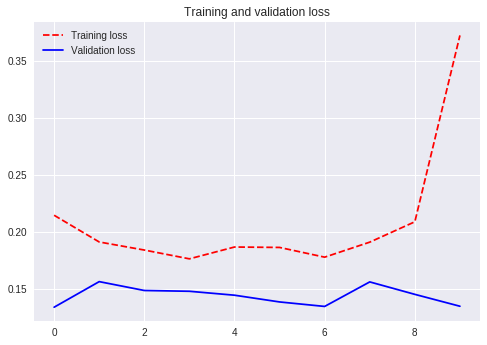

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# index = 0
# correct = 0
# for s, t in test_gen:
#         pred = model.predict(s)
#         print('predit:{}'.format(pred.argmax(axis=1)))
#         print('t:{}'.format(t.argmax(axis=1)))

# evaluation according to test dataset
index = 0
correct = 0
for s, t in test_gen:
        pred = model.predict(s)
        for s1,t1 in zip(pred.argmax(axis=1),t.argmax(axis=1)):
            if s1 == t1:
                correct += 1
            index += 1
        if index % 1000 == 0:
            print('index:{0},correct:{1}'.format(index,correct/index)) 
        if index > 10000:
            break


index:3000,correct:0.964
index:6000,correct:0.9435
index:9000,correct:0.9465555555555556


#### Deploy keras into andorid
1. freeze model to ".pb" file. 
2. deploy ".pb" file on andorid project and make predictions. [Here](https://medium.com/joytunes/deploying-a-tensorflow-model-to-android-69d04d1b0cba/) is reference and code written by java.


In [33]:
"""
Copyright (c) 2017, by the Authors: Amir H. Abdi
This software is freely available under the MIT Public License. 
Please see the License file in the root for details.

The following code snippet will convert the keras model file,
which is saved using model.save('kerasmodel_weight_file'),
to the freezed .pb tensorflow weight file which holds both the 
network architecture and its associated weights.
----------------------------------------------------------------
Input arguments:

num_output: this value has nothing to do with the number of classes, batch_size, etc., 
and it is mostly equal to 1. If the network is a **multi-stream network** 
(forked network with multiple outputs), set the value to the number of outputs.

quantize: if set to True, use the quantize feature of Tensorflow
(https://www.tensorflow.org/performance/quantization) [default: False]

use_theano: Thaeno and Tensorflow implement convolution in different ways.
When using Keras with Theano backend, the order is set to 'channels_first'.
This feature is not fully tested, and doesn't work with quantizization [default: False]

input_fld: directory holding the keras weights file [default: .]

output_fld: destination directory to save the tensorflow files [default: .]

input_model_file: name of the input weight file [default: 'model.h5']

output_model_file: name of the output weight file [default: args.input_model_file + '.pb']

graph_def: if set to True, will write the graph definition as an ascii file [default: False]

output_graphdef_file: if graph_def is set to True, the file name of the 
graph definition [default: model.ascii]

output_node_prefix: the prefix to use for output nodes. [default: output_node]
"""

import argparse
parser = argparse.ArgumentParser(description='set input arguments')
parser.add_argument('-input_fld', action="store", 
                    dest='input_fld', type=str, default='.')
parser.add_argument('-output_fld', action="store", 
                    dest='output_fld', type=str, default='')
parser.add_argument('-input_model_file', action="store", 
                    dest='input_model_file', type=str, default='weather.h5')
parser.add_argument('-output_model_file', action="store", 
                    dest='output_model_file', type=str, default='')
parser.add_argument('-output_graphdef_file', action="store", 
                    dest='output_graphdef_file', type=str, default='model.ascii')
parser.add_argument('-num_outputs', action="store", 
                    dest='num_outputs', type=int, default=1)
parser.add_argument('-graph_def', action="store", 
                    dest='graph_def', type=bool, default=False)
parser.add_argument('-output_node_prefix', action="store", 
                    dest='output_node_prefix', type=str, default='output_node')
parser.add_argument('-quantize', action="store", 
                    dest='quantize', type=bool, default=False)
parser.add_argument('-theano_backend', action="store", 
                    dest='theano_backend', type=bool, default=False)
parser.add_argument('-f')
args = parser.parse_args()
parser.print_help()
print('input args: ', args)

if args.theano_backend is True and args.quantize is True:
    raise ValueError("Quantize feature does not work with theano backend.")

# initialization
from keras.models import load_model
import tensorflow as tf
from pathlib import Path
from keras import backend as K

output_fld =  args.input_fld if args.output_fld == '' else args.output_fld
if args.output_model_file == '':
    args.output_model_file = str(Path(args.input_model_file).name) + '.pb'
Path(output_fld).mkdir(parents=True, exist_ok=True)    
weight_file_path = str(Path(args.input_fld) / args.input_model_file)
    
# load keras
K.set_learning_phase(0)
if args.theano_backend:
    K.set_image_data_format('channels_first')
else:
    K.set_image_data_format('channels_last')

try:
    net_model = load_model(weight_file_path)
except ValueError as err:
    print('''Input file specified ({}) only holds the weights, and not the model defenition.
    Save the model using mode.save(filename.h5) which will contain the network architecture
    as well as its weights. 
    If the model is saved using model.save_weights(filename.h5), the model architecture is 
    expected to be saved separately in a json format and loaded prior to loading the weights.
    Check the keras documentation for more details (https://keras.io/getting-started/faq/)'''
          .format(weight_file_path))
    raise err
num_output = args.num_outputs
pred = [None]*num_output
pred_node_names = [None]*num_output
for i in range(num_output):
    pred_node_names[i] = args.output_node_prefix+str(i)
    pred[i] = tf.identity(net_model.outputs[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)
                
# ascii
sess = K.get_session()

if args.graph_def:
    f = args.output_graphdef_file 
    tf.train.write_graph(sess.graph.as_graph_def(), output_fld, f, as_text=True)
    print('saved the graph definition in ascii format at: ', str(Path(output_fld) / f))

# convert and save
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from tensorflow.tools.graph_transforms import TransformGraph
if args.quantize:
    transforms = ["quantize_weights", "quantize_nodes"]
    transformed_graph_def = TransformGraph(sess.graph.as_graph_def(), [], pred_node_names, transforms)
    constant_graph = graph_util.convert_variables_to_constants(sess, transformed_graph_def, pred_node_names)
else:
    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)    
graph_io.write_graph(constant_graph, output_fld, args.output_model_file, as_text=False)
print('saved the freezed graph (ready for inference) at: ', str(Path(output_fld) / args.output_model_file))

# update to google drive
# Authenticate and create the PyDrive client.
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink","id": '1QiH6uMc9VuZLku4rybq8Eey7rR2cBKW1'}]})
f.SetContentFile('weather.h5.pb')
f.Upload()
print('Uploaded file with ID {}'.format(f.get('id')))
# double check 
g = tf.GraphDef()
g.ParseFromString(open("weather.h5.pb", "rb").read())
# check nodes
[n for n in g.node if n.name.find("input") != -1]
[n for n in g.node if n.name.find("output") != -1]


usage: ipykernel_launcher.py [-h] [-input_fld INPUT_FLD]
                             [-output_fld OUTPUT_FLD]
                             [-input_model_file INPUT_MODEL_FILE]
                             [-output_model_file OUTPUT_MODEL_FILE]
                             [-output_graphdef_file OUTPUT_GRAPHDEF_FILE]
                             [-num_outputs NUM_OUTPUTS] [-graph_def GRAPH_DEF]
                             [-output_node_prefix OUTPUT_NODE_PREFIX]
                             [-quantize QUANTIZE]
                             [-theano_backend THEANO_BACKEND] [-f F]

set input arguments

optional arguments:
  -h, --help            show this help message and exit
  -input_fld INPUT_FLD
  -output_fld OUTPUT_FLD
  -input_model_file INPUT_MODEL_FILE
  -output_model_file OUTPUT_MODEL_FILE
  -output_graphdef_file OUTPUT_GRAPHDEF_FILE
  -num_outputs NUM_OUTPUTS
  -graph_def GRAPH_DEF
  -output_node_prefix OUTPUT_NODE_PREFIX
  -quantize QUANTIZE
  -theano_backend THEANO_BACKEND
 

[name: "output_node0"
 op: "Identity"
 input: "dense_2_1/Softmax"
 attr {
   key: "T"
   value {
     type: DT_FLOAT
   }
 }]